# Mixture Density Network

Reproducing the classic Bishop MDN network tasks in Keras. The idea in this task is to predict a the value of an inverse sine function. This function has multiple real-valued solutions at each point, so the ANN model needs to have the capacity to handle this in it's loss function. An MDN is a good way to handle the predictions of these multiple output values.

There's a couple of other versions of this task, and this implementation owes much to the following:

- [David Ha - Mixture Density Networks with TensorFlow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)
- [Mixture Density Networks in Edward](http://edwardlib.org/tutorials/mixture-density-network)

In [1]:
# Normal imports for everybody
from context import * # imports the MDN layer 
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib widget

# Tensorflow is used to convert to tflite
import tensorflow as tf


2024-06-15 14:58:38.296307: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 14:58:38.389132: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-15 14:58:38.974145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 14:58:38.974227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 14:58:39.090161: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Generate Synthetic Data

Data generation

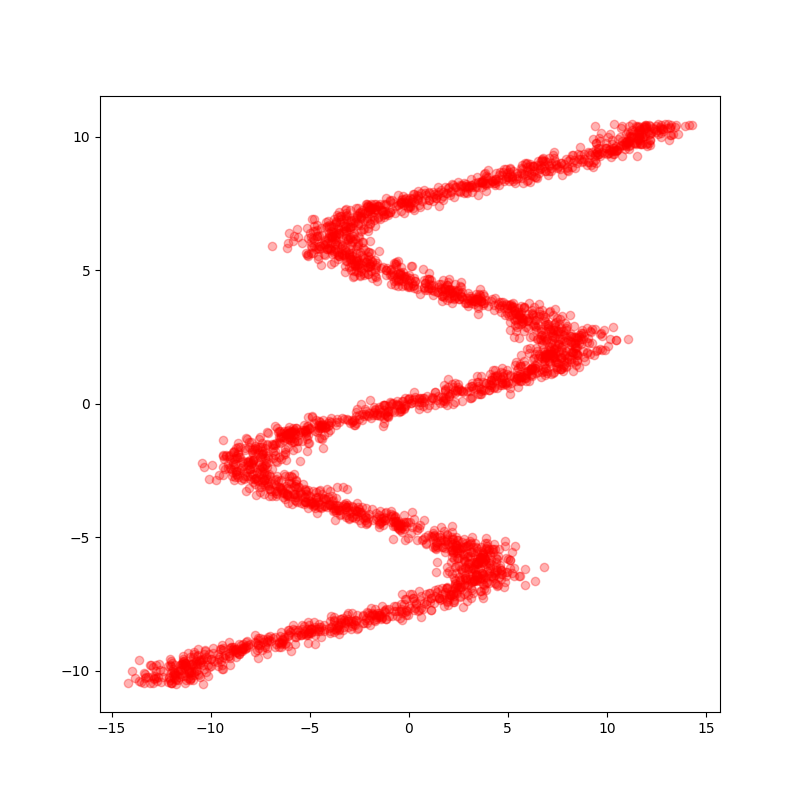

In [2]:
## Generating some data:
NSAMPLE = 3000

y_data = np.float32(np.random.uniform(-10.5, 10.5, NSAMPLE))
r_data = np.random.normal(size=NSAMPLE)
x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1
x_data = x_data.reshape((NSAMPLE, 1))
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

## Build the MDN Model

Now we will construct the MDN model in Keras. This uses the `Sequential` model interface in Keras.

The `MDN` layer comes after one or more `Dense` layers. You need to define the output dimension and number of mixtures for the MDN like so: `MDN(output_dimension, number_mixtures)`.

For this problem, we only need an output dimension of 1 as we are predicting one value (y). Adding more mixtures adds a more parameters (model is more complex, takes longer to train), but might help make the solutions better. You can see from the training data that there are at maximum 5 different layers to predict in the curve, so setting `N_MIXES = 5` is a good place to start.

For MDNs, we have to use a special loss function that can handle the mixture parameters: the function has to take into account the number of output dimensions and mixtures.

In [3]:
N_HIDDEN = 15
N_MIXES = 10

model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(keras.layers.Dense(N_HIDDEN, activation='relu'))
model.add(mdn.MDN(1, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(1,N_MIXES), optimizer=keras.optimizers.Adam()) #, metrics=[mdn.get_mixture_mse_accuracy(1,N_MIXES)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                30        
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 mdn (MDN)                   (None, 30)                480       
                                                                 
Total params: 750 (2.93 KB)
Trainable params: 750 (2.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training the model

Now we train the model using Keras' normal `fit` command.

In [5]:
history = model.fit(x=x_data, y=y_data, batch_size=128, epochs=500, validation_split=0.15)

Epoch 1/500
20/20 [==============================] - 5s 67ms/step - loss: 5.4749 - val_loss: 4.9662
Epoch 2/500
20/20 [==============================] - 0s 5ms/step - loss: 4.6111 - val_loss: 4.3019
Epoch 3/500
20/20 [==============================] - 0s 5ms/step - loss: 4.1181 - val_loss: 3.9534
Epoch 4/500
20/20 [==============================] - 0s 5ms/step - loss: 3.8426 - val_loss: 3.7393
Epoch 5/500
20/20 [==============================] - 0s 5ms/step - loss: 3.6447 - val_loss: 3.6032
Epoch 6/500
20/20 [==============================] - 0s 5ms/step - loss: 3.5228 - val_loss: 3.5208
Epoch 7/500
20/20 [==============================] - 0s 6ms/step - loss: 3.4434 - val_loss: 3.4924
Epoch 8/500
20/20 [==============================] - 0s 7ms/step - loss: 3.3915 - val_loss: 3.4130
Epoch 9/500
20/20 [==============================] - 0s 6ms/step - loss: 3.3179 - val_loss: 3.3538
Epoch 10/500
20/20 [==============================] - 0s 6ms/step - loss: 3.2624 - val_loss: 3.2979
Epoch 11

### Training and Validation Loss

It's interesting to see how the model trained. We can see that after a certain point training is rather slow.

For this problem a loss value around 1.5 produces quite good results.

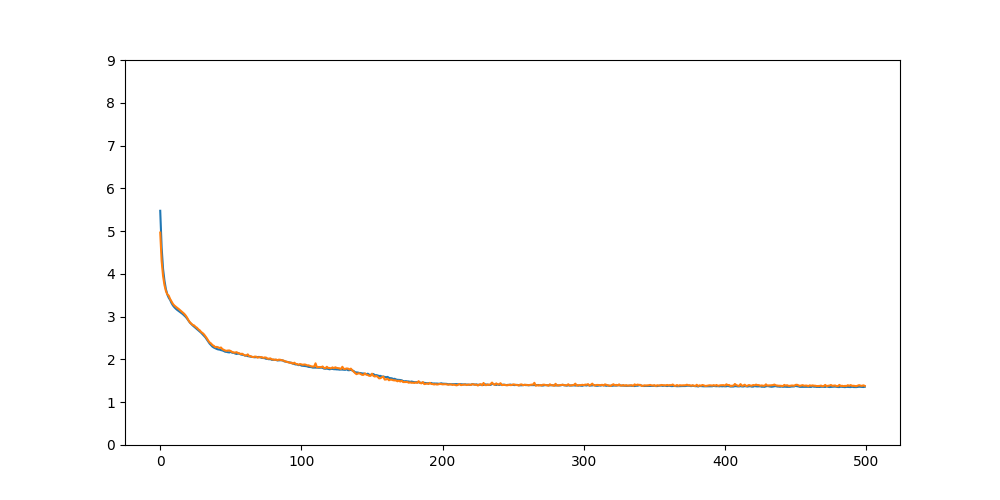

In [6]:
plt.figure(figsize=(10, 5))
plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## Sampling Functions

The MDN model outputs parameters of a mixture model---a list of means (mu), variances (sigma), and weights (pi).

The `mdn` module provides a function to sample from these parameters as follows. First the parameters are split up into `mu`s, `sigma`s and `pi`s, then the categorical distribution formed by the `pi`s is sampled to choose which mixture component should be sampled, then that component's `mu`s and `sigma`s is used to sample from a multivariate normal model, here's the code:

    def sample_from_output(params, output_dim, num_mixes, temp=1.0):
        """Sample from an MDN output with temperature adjustment."""
        mus = params[:num_mixes*output_dim]
        sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
        pis = softmax(params[-num_mixes:], t=temp)
        m = sample_from_categorical(pis)
        # Alternative way to sample from categorical:
        # m = np.random.choice(range(len(pis)), p=pis)
        mus_vector = mus[m*output_dim:(m+1)*output_dim]
        sig_vector = sigs[m*output_dim:(m+1)*output_dim] * temp  # adjust for temperature
        cov_matrix = np.identity(output_dim) * sig_vector
        sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
        return sample
        
If you only have one prediction to sample from, you can use the function as is; but if you need to sample from a lot of predictions at once (as in the following sections), you can use `np.apply_along_axis` to apply it to a whole numpy array of predicted parameters.

## Try out the MDN Model

Now we try out the model by making predictions at 3000 evenly spaced points on the x-axis. 

Mixture models output lists of parameters, so we're going to sample from these parameters for each point on the x-axis, and also try plotting the parameters themselves so we can have some insight into what the model is learning!

In [7]:
## Sample on some test data:
x_test = np.float32(np.arange(-15,15,0.01))
NTEST = x_test.size
print("Testing:", NTEST, "samples.")
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

# Make predictions from the model
y_test = model.predict(x_test)
# y_test contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Sample from the predicted distributions
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, y_test, 1, N_MIXES,temp=1.0)

# Split up the mixture parameters (for future fun)
mus = np.apply_along_axis((lambda a: a[:N_MIXES]),1, y_test)
sigs = np.apply_along_axis((lambda a: a[N_MIXES:2*N_MIXES]),1, y_test)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[2*N_MIXES:])),1, y_test)

Testing: 3000 samples.
94/94 [==============================] - 0s 1ms/step


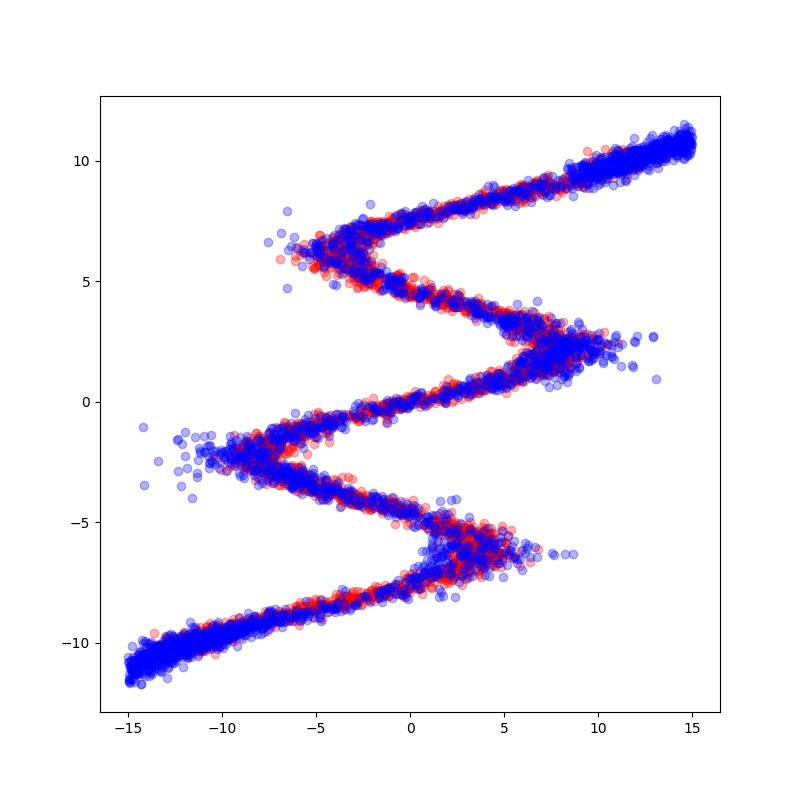

In [8]:
# Plot the samples
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, y_samples[:,:,0], 'bo',alpha=0.3)
plt.show()
# These look pretty good!

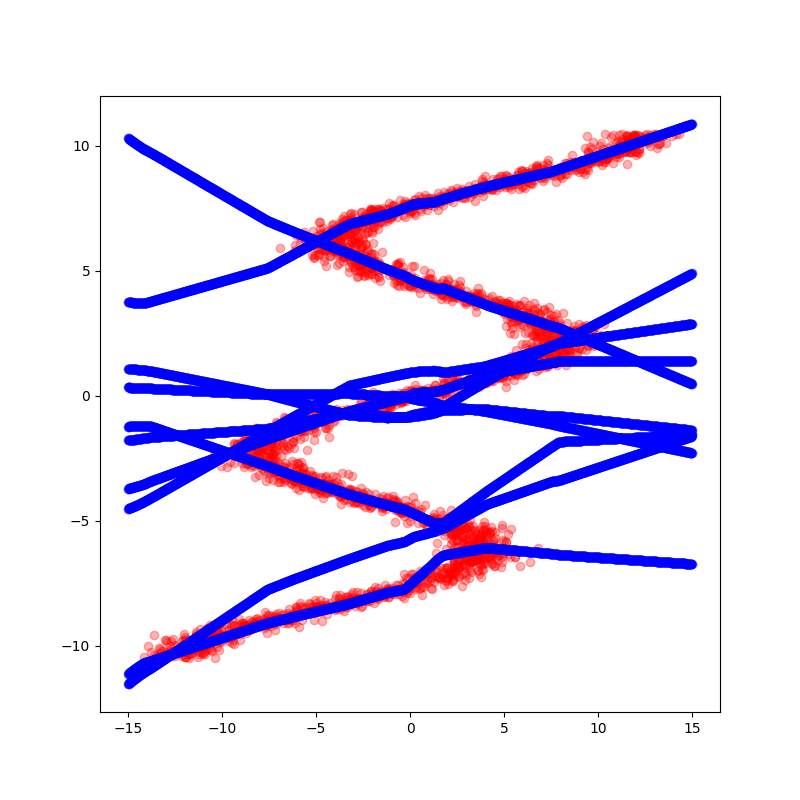

In [9]:
# Plot the means - this gives us some insight into how the model learns to produce the mixtures.
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, mus,'bo',alpha=0.3)
plt.show()
# Cool!

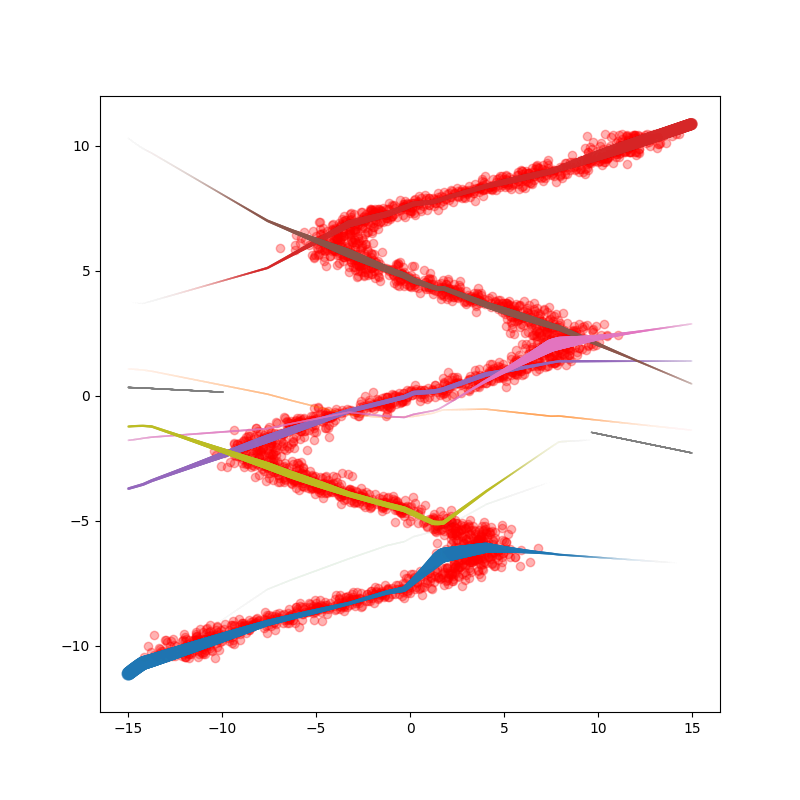

In [10]:
# Let's plot the variances and weightings of the means as well.
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
# ax1.scatter(data[0], data[1], marker='o', c='b', s=data[2], label='the data')
ax1.scatter(x_data,y_data,marker='o', c='r', alpha=0.3)
for i in range(N_MIXES):
    ax1.scatter(x_test, mus[:,i], marker='o', s=200*sigs[:,i]*pis[:,i],alpha=0.3)
plt.show()

## Converting to TensorFlow Lite

We will now convert the keras model into a tflite model. This primarily uses boilerplate code which invokes the TFLiteConverter class and writes the generated model to file. This conversion currently outputs a significant amount of arithmetic conversion errors. From other posts online, this seems to be a superficial issue with converting from 32 bit ints to 64 bit ints and does not affect the validity of the conversion.

In [11]:
# Following code converts high level keras model to a .tflite file 
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()
# Saves converted file to this folder
tflite_model_name = '1-sineprediction-lite.tflite'
with open(tflite_model_name, 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: /tmp/tmp02bn26dp/assets


INFO:tensorflow:Assets written to: /tmp/tmp02bn26dp/assets
2024-06-15 15:00:09.251037: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-15 15:00:09.251094: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-15 15:00:09.251430: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp02bn26dp
2024-06-15 15:00:09.252498: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-15 15:00:09.252511: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp02bn26dp
2024-06-15 15:00:09.255554: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-06-15 15:00:09.256532: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-15 15:00:09.308268: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

## Predicting using the TensorFlow Lite Model

To make predictions using the tflite runtime, we use the interpreter class. Primarily, this is boilerplate code provided from the tensorflow tutorials. Importantly as our has a model dynamic input shape (as indicated by us defining the keras model with a first layer with batch_input_shape=(None, 1)) we must define the input tensor manually using resize_tensor_input. Now, we will test the tflite model on our original training data and compare it to the keras model.

In [12]:
# Load the TFLite model and allocate tensors.
# Note that it assumes we are loading the model just saved to the current folder
# to interpret from a model we have just generated, use model_content=tflite_model as the parameter instead
interpreter = tf.lite.Interpreter(model_path=tflite_model_name) 

# Resize input shape for dynamic shape model and allocate tensor
interpreter.resize_tensor_input(interpreter.get_input_details()[0]['index'], (NTEST,1))
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on our defined testing set
interpreter.set_tensor(input_details[0]['index'], x_test)

# Uses the interpreter to make the same predictions as our keras model
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
y_test_tflite = interpreter.get_tensor(output_details[0]['index'])


# Sample from the TFLite predicted distributions as done previously
y_samples_tflite = np.apply_along_axis(mdn.sample_from_output, 1, y_test_tflite, 1, N_MIXES, temp=1.0)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


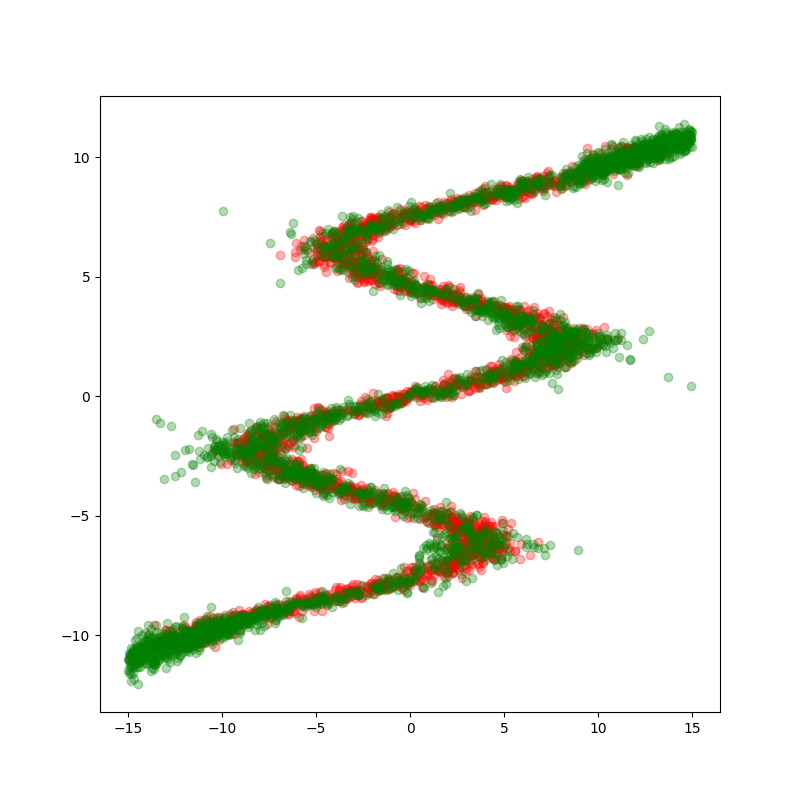

In [13]:
# Plot the samples
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, y_samples_tflite[:,:,0], 'go',alpha=0.3)
plt.show()
# The model clearly successfully predicts our dataset.

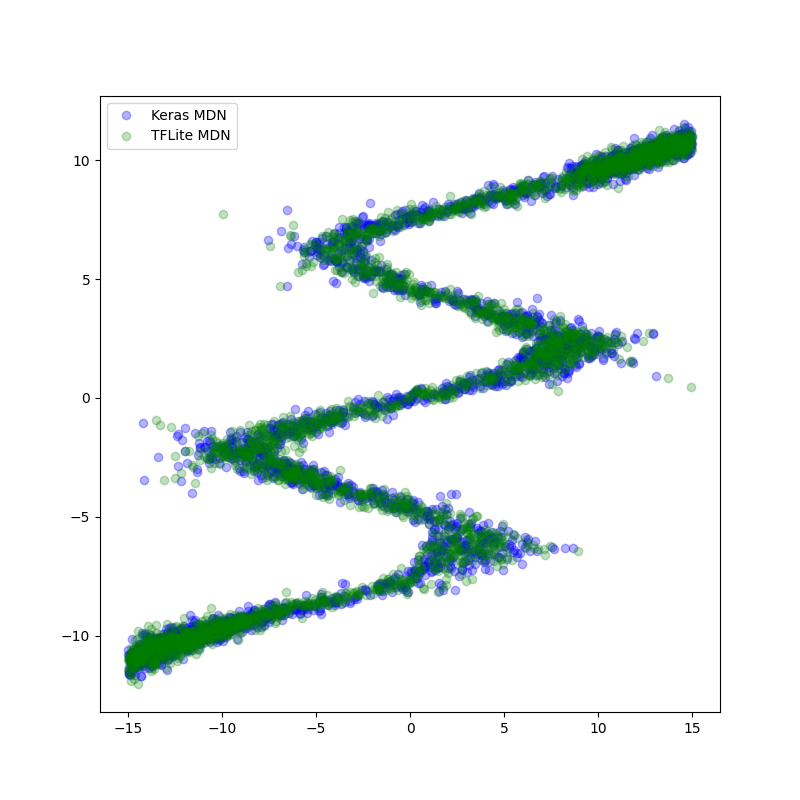

In [14]:
# Plot the Keras and TFLite model predictions
plt.figure(figsize=(8, 8))
plt.plot(x_test, y_samples[:,:,0], 'bo', label='Keras MDN', alpha=0.3)
plt.plot(x_test, y_samples_tflite[:,:,0], 'go', label='TFLite MDN', alpha=0.25)
plt.legend()
plt.show()
# The models clearly behave quite similarly

In [15]:
mse = np.mean((y_samples - y_samples_tflite)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_samples - y_samples_tflite))
correlation = np.corrcoef(y_samples.ravel(), y_samples_tflite.ravel())[0, 1]

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Correlation Coefficient: {correlation}")

# All seem useless

MSE: 32.53943961155324
RMSE: 5.704335159468914
MAE: 3.763231828655017
Correlation Coefficient: 0.7062793446848046
